# Model 1

— To explore the relationship between **user demographics (age, gender)** and **engagement** in gender-based violence discussions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import re
from ast import literal_eval

import matplotlib.cm as cm
import numpy as np

In [2]:
df = pd.read_csv('preprocessed_dataset.csv')
holidays = pd.read_csv('ph_holidays.csv')

In [3]:
df.head()

,title,body,link,author,created,upvotes,num_comments,subreddit,search_input,age_gender,...,day,post_length,day_of_week,is_weekend,time_of_day,upvotes_relative,subreddit_size,upvotes_per_capita,body_text,relationship
0,"['I', ""n't"", 'care', ""'re"", 'girl', ',', 'unso...","['So', 'like', 'many', 'people', 'subreddit', ...",https://www.reddit.com/r/alasjuicy/comments/10...,t2_uzp1eor9,2023-01-10 18:35:34,126,20,alasjuicy,unsolicited pics,[],...,10,139,1,0,Evening,2.446154,247000,0.000510,"So like many people subreddit , I take nudes ....",partner
1,"['Unsolicited', 'Dick', 'Pics', 'Enjoyer']","['Bago', 'lang', 'ako', 'naging', 'active', 'd...",https://www.reddit.com/r/alasjuicy/comments/1a...,t2_9x1nt0ze2,2024-02-08 03:58:45,68,54,alasjuicy,unsolicited pics,[],...,8,125,3,0,Night,0.961844,247000,0.000275,Bago lang ako naging active dito sa AJ . Mostl...,unknown
2,"['UNSOLICITED', 'DICK', 'PIC']","['Hello', 'men', 'aj', '!', 'Eto', 'sakin', 'l...",https://www.reddit.com/r/alasjuicy/comments/18...,t2_q6lir5af,2023-11-27 19:50:18,84,59,alasjuicy,unsolicited pics,[],...,27,146,0,0,Evening,1.029428,247000,0.000340,Hello men aj ! Eto sakin lang ah . Para sakin ...,unknown
3,"['Unsolicited', '!', 'ck', 'pics']","['really', 'irks', 'knowing', 'na', 'ang', 'da...",https://www.reddit.com/r/alasjuicy/comments/1c...,t2_ssss4d1u,2024-04-16 23:39:01,17,36,alasjuicy,unsolicited pics,[],...,16,72,1,0,Evening,0.319948,247000,0.000069,really irks knowing na ang dami pa ring mga la...,unknown
4,"['Kelan', 'ba', 'titigil', 'unsolicited', 'dic...","['Pakiusap', 'naman', ',', 'di', 'porket', 'na...",https://www.reddit.com/r/alasjuicy/comments/1b...,t2_xb6pbdoh7,2024-04-03 18:35:41,45,46,alasjuicy,unsolicited pics,[],...,3,43,2,0,Evening,0.846920,247000,0.000182,"Pakiusap naman , di porket nagpost ako dito ka...",unknown


In [4]:
holidays.head()

,Date,Holiday,Type
0,01-01,New Year's Day,Regular
1,03-28,Maundy Thursday,Regular
2,03-29,Good Friday,Regular
3,04-09,Araw ng Kagitingan,Regular
4,05-01,Labor Day,Regular


In [5]:
def convert_date(date_str):
    return pd.to_datetime('2000-' + date_str, format='%Y-%m-%d')

holidays['Date'] = holidays['Date'].apply(convert_date)
holidays['Date'] = holidays['Date'].dt.normalize()
holidays.head()

,Date,Holiday,Type
0,2000-01-01,New Year's Day,Regular
1,2000-03-28,Maundy Thursday,Regular
2,2000-03-29,Good Friday,Regular
3,2000-04-09,Araw ng Kagitingan,Regular
4,2000-05-01,Labor Day,Regular


In [6]:
df.rename(columns={'created': 'post_date'}, inplace=True)

In [7]:
post_count = df.groupby(['month', 'day']).size().reset_index(name='post_count')

In [8]:
df = df.merge(post_count, on=['month', 'day'], how='left')

In [9]:
post_count

,month,day,post_count
0,1,1,4
1,1,2,5
2,1,3,4
3,1,4,9
4,1,5,6
...,...,...,...
353,12,27,6
354,12,28,9
355,12,29,4
356,12,30,5


In [10]:
df.head()

,title,body,link,author,post_date,upvotes,num_comments,subreddit,search_input,age_gender,...,post_length,day_of_week,is_weekend,time_of_day,upvotes_relative,subreddit_size,upvotes_per_capita,body_text,relationship,post_count
0,"['I', ""n't"", 'care', ""'re"", 'girl', ',', 'unso...","['So', 'like', 'many', 'people', 'subreddit', ...",https://www.reddit.com/r/alasjuicy/comments/10...,t2_uzp1eor9,2023-01-10 18:35:34,126,20,alasjuicy,unsolicited pics,[],...,139,1,0,Evening,2.446154,247000,0.000510,"So like many people subreddit , I take nudes ....",partner,3
1,"['Unsolicited', 'Dick', 'Pics', 'Enjoyer']","['Bago', 'lang', 'ako', 'naging', 'active', 'd...",https://www.reddit.com/r/alasjuicy/comments/1a...,t2_9x1nt0ze2,2024-02-08 03:58:45,68,54,alasjuicy,unsolicited pics,[],...,125,3,0,Night,0.961844,247000,0.000275,Bago lang ako naging active dito sa AJ . Mostl...,unknown,6
2,"['UNSOLICITED', 'DICK', 'PIC']","['Hello', 'men', 'aj', '!', 'Eto', 'sakin', 'l...",https://www.reddit.com/r/alasjuicy/comments/18...,t2_q6lir5af,2023-11-27 19:50:18,84,59,alasjuicy,unsolicited pics,[],...,146,0,0,Evening,1.029428,247000,0.000340,Hello men aj ! Eto sakin lang ah . Para sakin ...,unknown,7
3,"['Unsolicited', '!', 'ck', 'pics']","['really', 'irks', 'knowing', 'na', 'ang', 'da...",https://www.reddit.com/r/alasjuicy/comments/1c...,t2_ssss4d1u,2024-04-16 23:39:01,17,36,alasjuicy,unsolicited pics,[],...,72,1,0,Evening,0.319948,247000,0.000069,really irks knowing na ang dami pa ring mga la...,unknown,12
4,"['Kelan', 'ba', 'titigil', 'unsolicited', 'dic...","['Pakiusap', 'naman', ',', 'di', 'porket', 'na...",https://www.reddit.com/r/alasjuicy/comments/1b...,t2_xb6pbdoh7,2024-04-03 18:35:41,45,46,alasjuicy,unsolicited pics,[],...,43,2,0,Evening,0.846920,247000,0.000182,"Pakiusap naman , di porket nagpost ako dito ka...",unknown,7


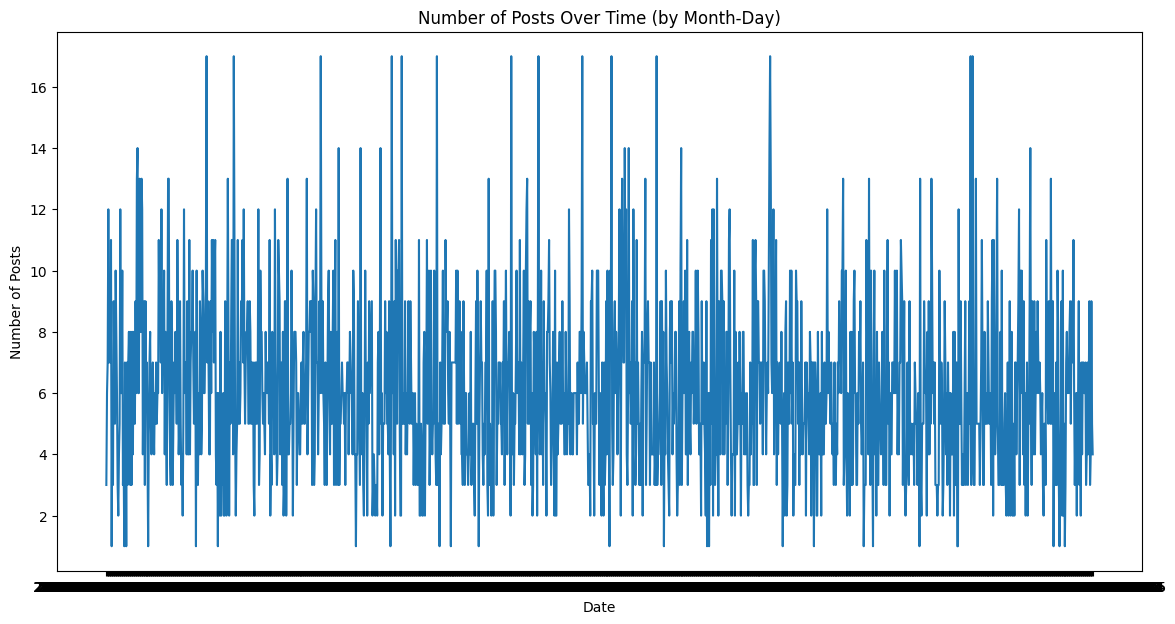

In [11]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='post_date', y='post_count')
plt.title('Number of Posts Over Time (by Month-Day)')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

In [12]:
df['engagement'] = df['upvotes'] + df['num_comments']

In [13]:
df.head()

,title,body,link,author,post_date,upvotes,num_comments,subreddit,search_input,age_gender,...,day_of_week,is_weekend,time_of_day,upvotes_relative,subreddit_size,upvotes_per_capita,body_text,relationship,post_count,engagement
0,"['I', ""n't"", 'care', ""'re"", 'girl', ',', 'unso...","['So', 'like', 'many', 'people', 'subreddit', ...",https://www.reddit.com/r/alasjuicy/comments/10...,t2_uzp1eor9,2023-01-10 18:35:34,126,20,alasjuicy,unsolicited pics,[],...,1,0,Evening,2.446154,247000,0.000510,"So like many people subreddit , I take nudes ....",partner,3,146
1,"['Unsolicited', 'Dick', 'Pics', 'Enjoyer']","['Bago', 'lang', 'ako', 'naging', 'active', 'd...",https://www.reddit.com/r/alasjuicy/comments/1a...,t2_9x1nt0ze2,2024-02-08 03:58:45,68,54,alasjuicy,unsolicited pics,[],...,3,0,Night,0.961844,247000,0.000275,Bago lang ako naging active dito sa AJ . Mostl...,unknown,6,122
2,"['UNSOLICITED', 'DICK', 'PIC']","['Hello', 'men', 'aj', '!', 'Eto', 'sakin', 'l...",https://www.reddit.com/r/alasjuicy/comments/18...,t2_q6lir5af,2023-11-27 19:50:18,84,59,alasjuicy,unsolicited pics,[],...,0,0,Evening,1.029428,247000,0.000340,Hello men aj ! Eto sakin lang ah . Para sakin ...,unknown,7,143
3,"['Unsolicited', '!', 'ck', 'pics']","['really', 'irks', 'knowing', 'na', 'ang', 'da...",https://www.reddit.com/r/alasjuicy/comments/1c...,t2_ssss4d1u,2024-04-16 23:39:01,17,36,alasjuicy,unsolicited pics,[],...,1,0,Evening,0.319948,247000,0.000069,really irks knowing na ang dami pa ring mga la...,unknown,12,53
4,"['Kelan', 'ba', 'titigil', 'unsolicited', 'dic...","['Pakiusap', 'naman', ',', 'di', 'porket', 'na...",https://www.reddit.com/r/alasjuicy/comments/1b...,t2_xb6pbdoh7,2024-04-03 18:35:41,45,46,alasjuicy,unsolicited pics,[],...,2,0,Evening,0.846920,247000,0.000182,"Pakiusap naman , di porket nagpost ako dito ka...",unknown,7,91


In [14]:
df['body_text'] = df['body_text'].fillna('')

df[['age', 'gender']] = df['age_gender'].str.extract(r'(\d+)?\s*(\w+)?')
df['age'] = pd.to_numeric(df['age'], errors='coerce')

df['post_date'] = pd.to_datetime(df['post_date'])

time_of_day_mapping = {
    'Morning': 'Morning',
    'Afternoon': 'Afternoon',
    'Evening': 'Evening',
    'Night': 'Night'
}
df['time_of_day'] = df['time_of_day'].map(time_of_day_mapping)

data_cleaned = df.drop(columns=['age_gender'])

data_cleaned_info = data_cleaned.info()
data_cleaned_head = data_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731 entries, 0 to 1730
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               1731 non-null   object        
 1   body                1731 non-null   object        
 2   link                1731 non-null   object        
 3   author              1731 non-null   object        
 4   post_date           1731 non-null   datetime64[ns]
 5   upvotes             1731 non-null   int64         
 6   num_comments        1731 non-null   int64         
 7   subreddit           1731 non-null   object        
 8   search_input        1731 non-null   object        
 9   year                1731 non-null   int64         
 10  month               1731 non-null   int64         
 11  day                 1731 non-null   int64         
 12  post_length         1731 non-null   int64         
 13  day_of_week         1731 non-null   int64       

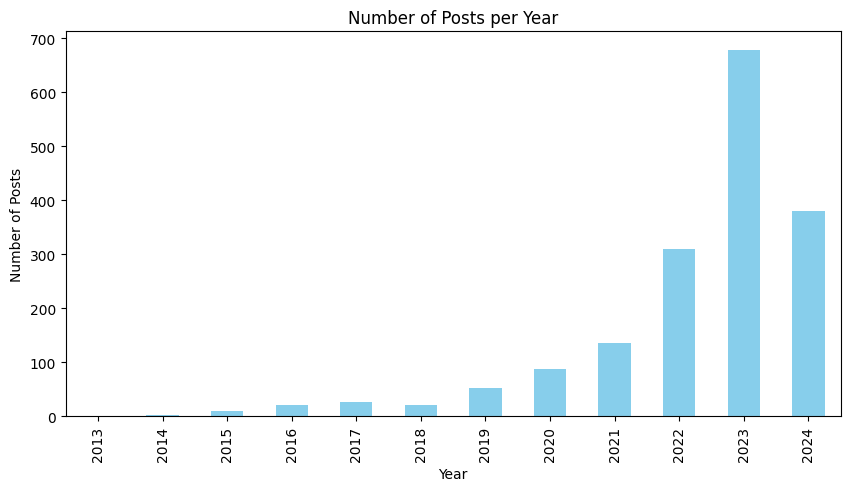

In [15]:
data_cleaned['post_date'] = pd.to_datetime(data_cleaned['post_date'])

yearly_counts = data_cleaned['post_date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10, 5))
yearly_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts per Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.show()

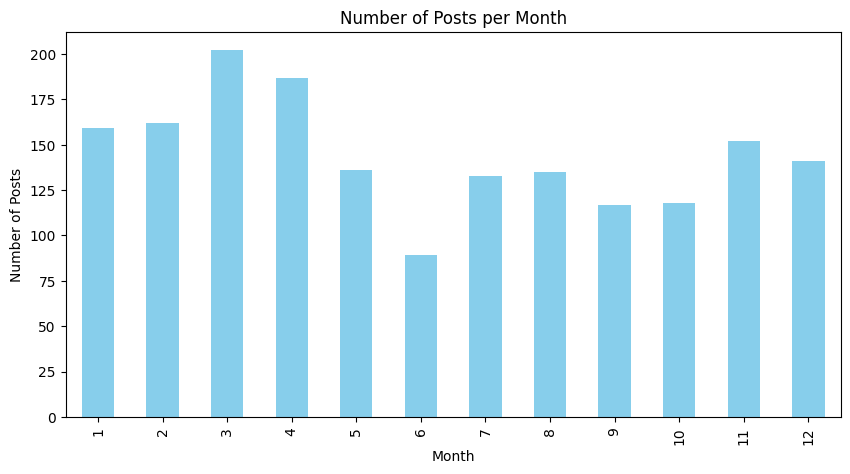

In [16]:
monthly_counts = data_cleaned['post_date'].dt.month.value_counts().sort_index()

plt.figure(figsize=(10, 5))
monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts per Month')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.show()

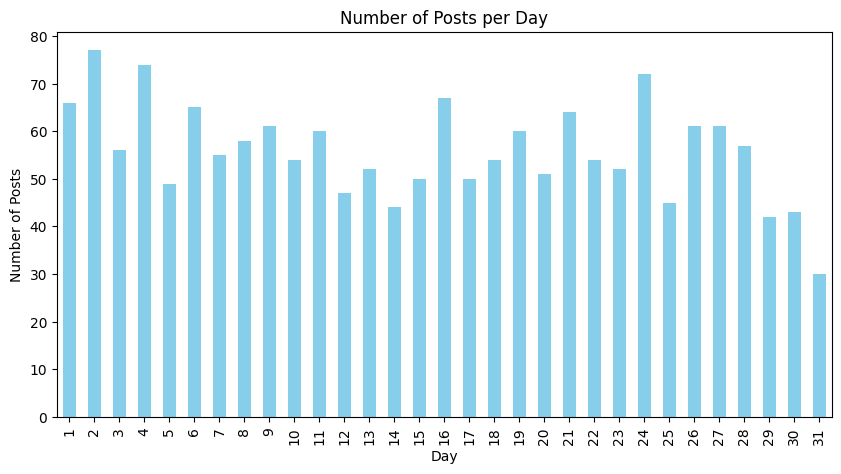

In [17]:
daily_counts = data_cleaned['post_date'].dt.day.value_counts().sort_index()

plt.figure(figsize=(10, 5))
daily_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts per Day')
plt.xlabel('Day')
plt.ylabel('Number of Posts')
plt.show()

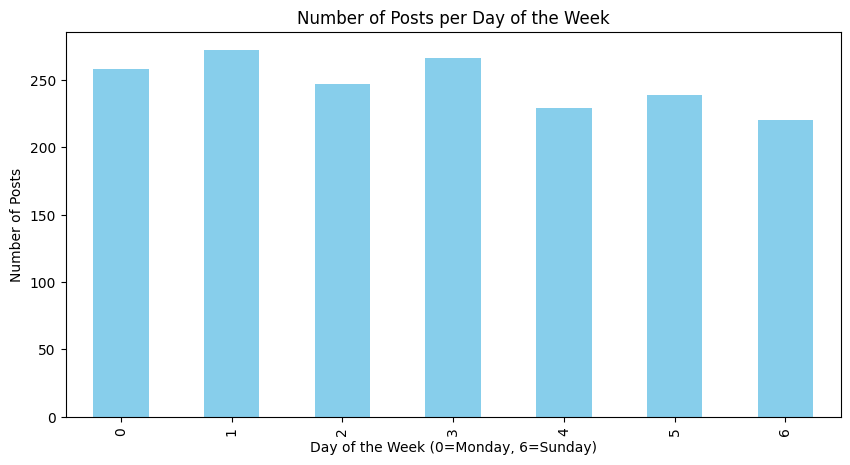

In [18]:
weekday_counts = data_cleaned['post_date'].dt.dayofweek.value_counts().sort_index()

plt.figure(figsize=(10, 5))
weekday_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts per Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Posts')
plt.show()

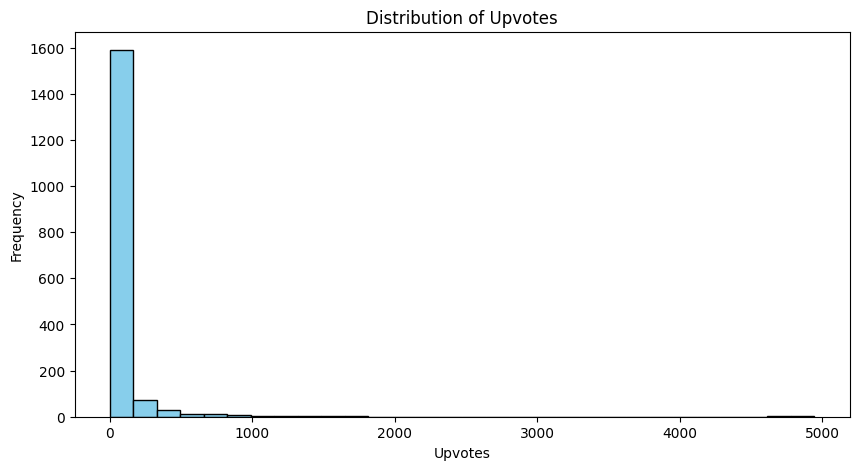

In [19]:
plt.figure(figsize=(10, 5))
data_cleaned['upvotes'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Upvotes')
plt.xlabel('Upvotes')
plt.ylabel('Frequency')
plt.show()

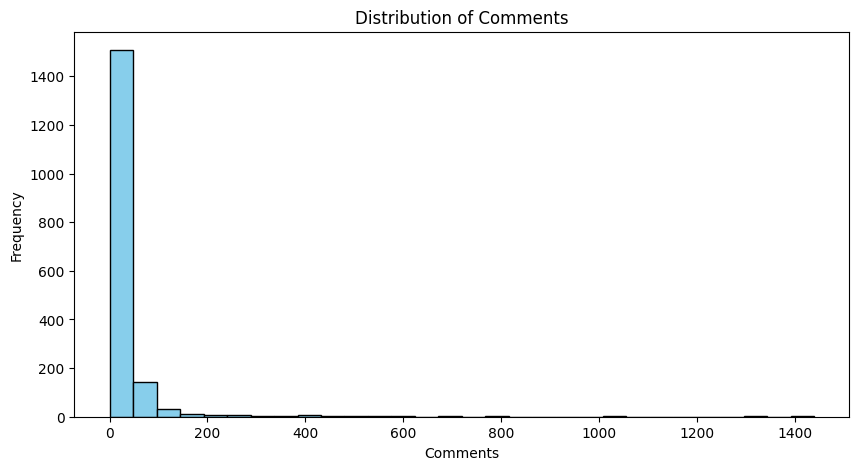

In [20]:
plt.figure(figsize=(10, 5))
data_cleaned['num_comments'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Comments')
plt.xlabel('Comments')
plt.ylabel('Frequency')
plt.show()

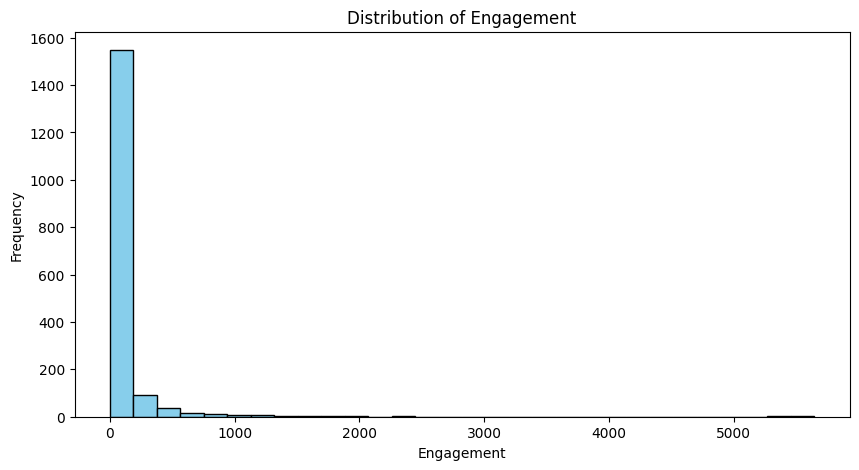

In [21]:
plt.figure(figsize=(10, 5))
data_cleaned['engagement'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Engagement')
plt.xlabel('Engagement')
plt.ylabel('Frequency')
plt.show()

In [22]:
df['year_month'] = df['post_date'].dt.to_period('M')

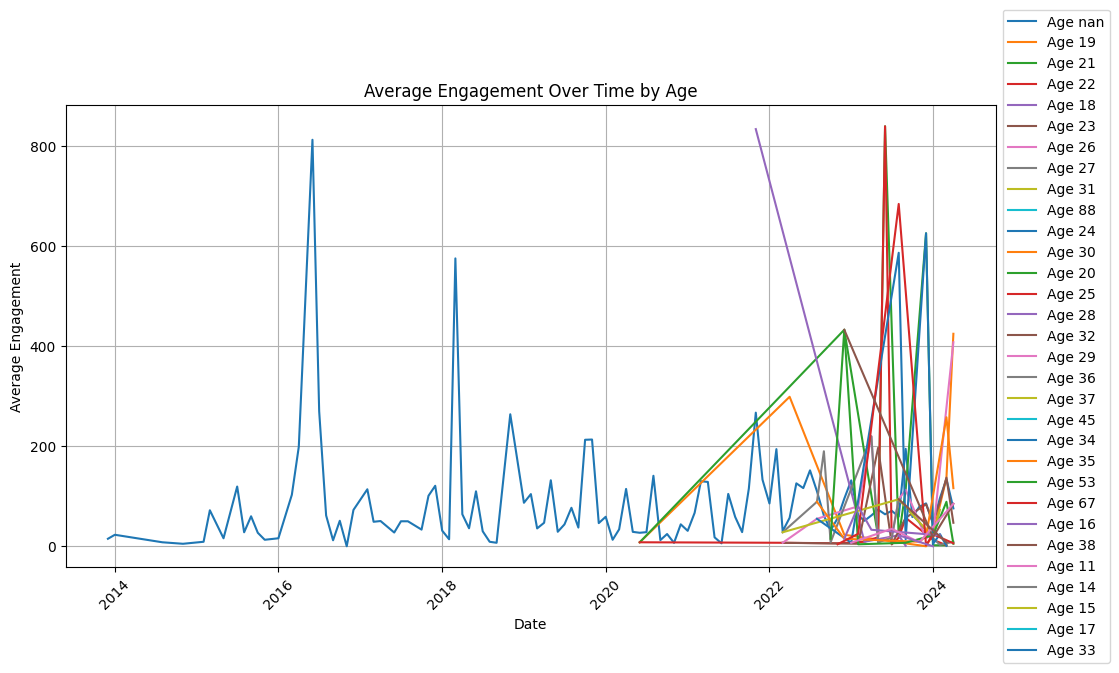

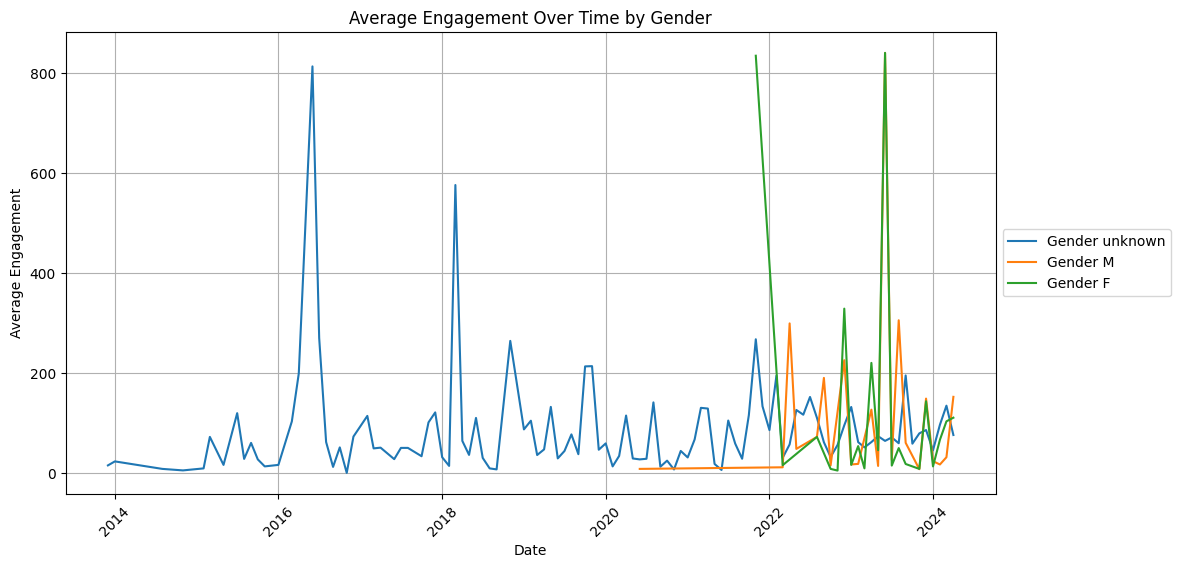

In [23]:
def extract_age_gender(age_gender_list):
    ages = []
    genders = []
    for entry in age_gender_list:
        # Updated regex to handle optional spaces between age and gender
        match = re.match(r'(\d+)\s*([MF])', entry.strip())
        if match:
            age, gender = match.groups()
            ages.append(age)
            genders.append(gender)
    return ages, genders

df['age_gender'] = df['age_gender'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

df['ages'], df['genders'] = zip(*df['age_gender'].apply(extract_age_gender))

df = df.explode('ages').explode('genders')

df['age'] = df['ages'].astype(str)
df['gender'] = df['genders']

df.drop(columns=['ages', 'genders'], inplace=True)

df['post_date'] = pd.to_datetime(df['post_date'])
df['year'] = df['post_date'].dt.year
df['month'] = df['post_date'].dt.month
df['day'] = df['post_date'].dt.day
df['day_of_week'] = df['post_date'].dt.dayofweek
df['year_month'] = df['post_date'].dt.to_period('M')

df['age'] = df['age'].fillna('unknown')
df['gender'] = df['gender'].fillna('unknown')

monthly_engagement = df.groupby(['year_month', 'age', 'gender'])['engagement'].mean().reset_index()

monthly_engagement['year_month'] = monthly_engagement['year_month'].dt.to_timestamp()

monthly_engagement_age = df.groupby(['year_month', 'age'])['engagement'].mean().reset_index()

monthly_engagement_age['year_month'] = monthly_engagement_age['year_month'].dt.to_timestamp()


plt.figure(figsize=(12, 6))
for age in monthly_engagement_age['age'].unique():
    subset = monthly_engagement_age[monthly_engagement_age['age'] == age]
    plt.plot(subset['year_month'], subset['engagement'], label=f'Age {age}')
plt.title('Average Engagement Over Time by Age')
plt.xlabel('Date')
plt.ylabel('Average Engagement')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

monthly_engagement_gender = df.groupby(['year_month', 'gender'])['engagement'].mean().reset_index()

monthly_engagement_gender['year_month'] = monthly_engagement_gender['year_month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
for gender in monthly_engagement_gender['gender'].unique():
    subset = monthly_engagement_gender[monthly_engagement_gender['gender'] == gender]
    plt.plot(subset['year_month'], subset['engagement'], label=f'Gender {gender}')
plt.title('Average Engagement Over Time by Gender')
plt.xlabel('Date')
plt.ylabel('Average Engagement')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

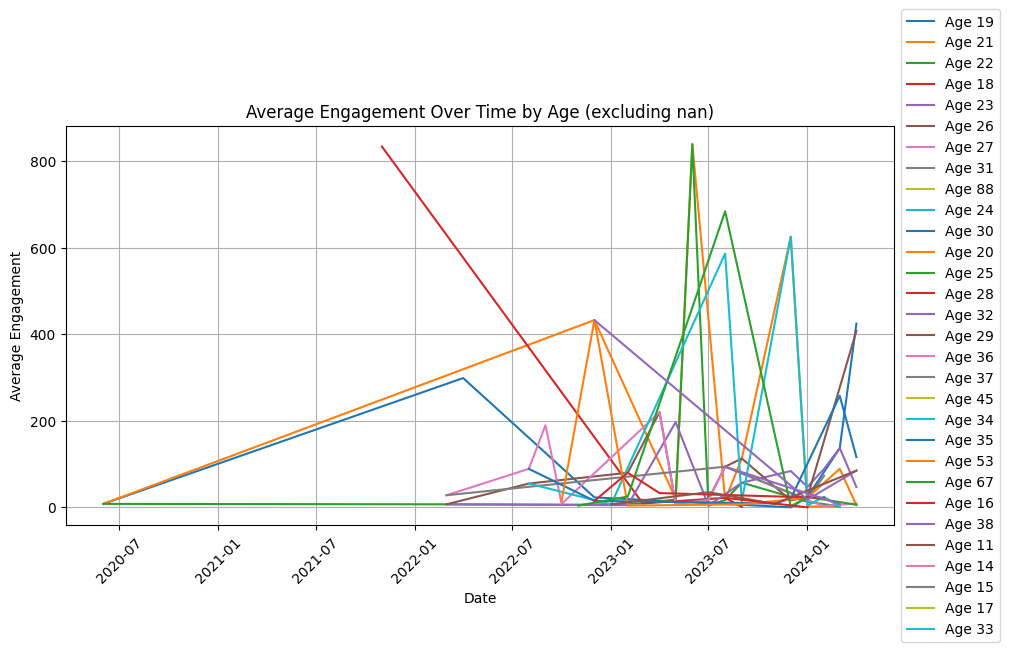

In [24]:
monthly_engagement_age_filtered = monthly_engagement_age[monthly_engagement_age['age'] != 'nan']

plt.figure(figsize=(12, 6))
for age in monthly_engagement_age_filtered['age'].unique():
    subset = monthly_engagement_age_filtered[monthly_engagement_age_filtered['age'] == age]
    plt.plot(subset['year_month'], subset['engagement'], label=f'Age {age}')
plt.title('Average Engagement Over Time by Age (excluding nan)')
plt.xlabel('Date')
plt.ylabel('Average Engagement')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


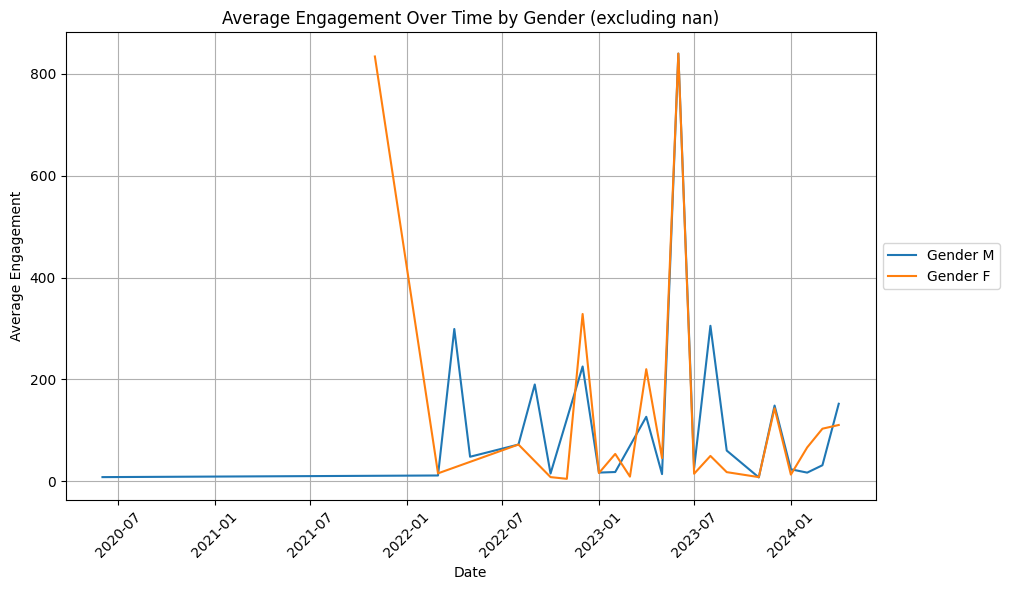

In [25]:
monthly_engagement_gender_filtered = monthly_engagement_gender[monthly_engagement_gender['gender'] != 'unknown']

plt.figure(figsize=(12, 6))
for gender in monthly_engagement_gender_filtered['gender'].unique():
    subset = monthly_engagement_gender_filtered[monthly_engagement_gender_filtered['gender'] == gender]
    plt.plot(subset['year_month'], subset['engagement'], label=f'Gender {gender}')
plt.title('Average Engagement Over Time by Gender (excluding nan)')
plt.xlabel('Date')
plt.ylabel('Average Engagement')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


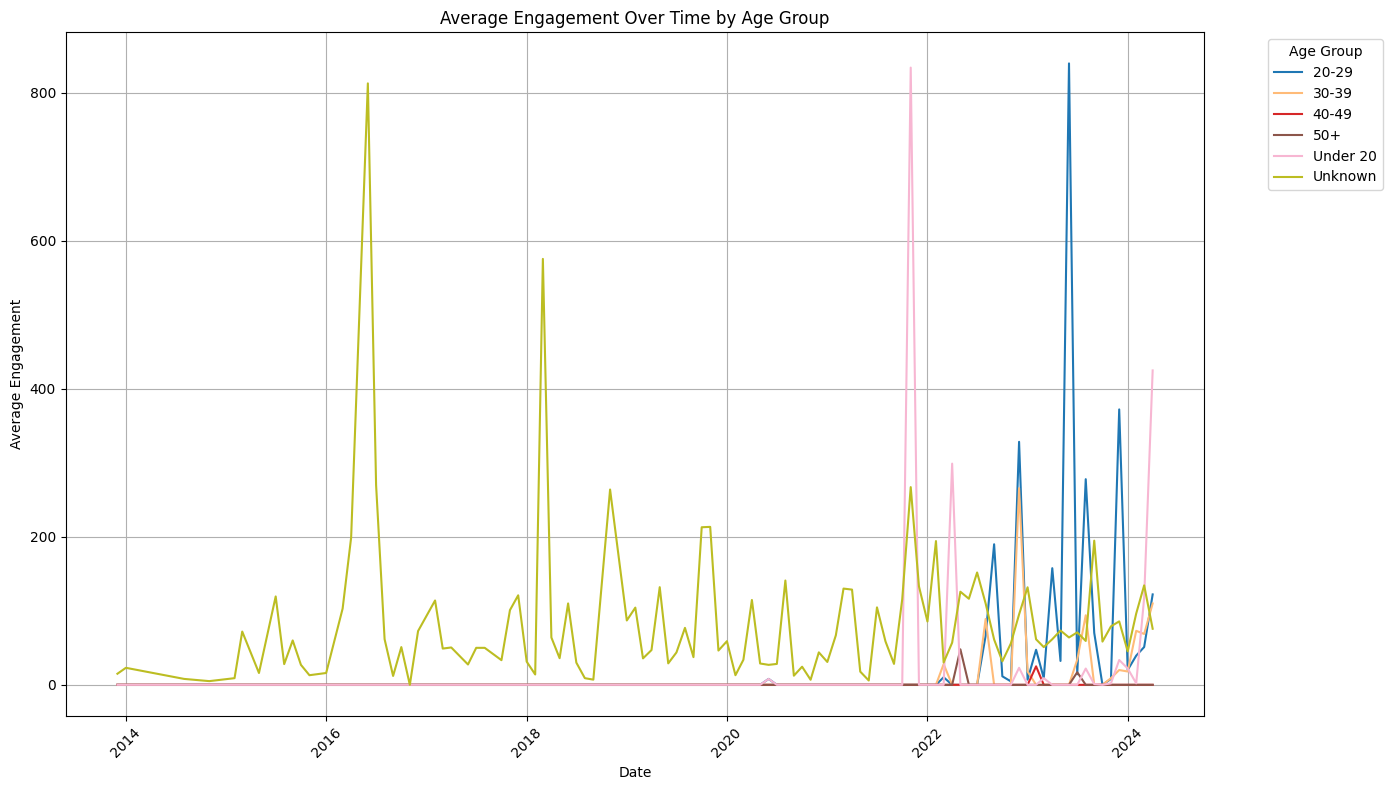

In [26]:
def age_group(age):
    if pd.isna(age) or age == 'nan':
        return 'Unknown'
    age = int(age)
    if age < 20:
        return 'Under 20'
    elif age < 30:
        return '20-29'
    elif age < 40:
        return '30-39'
    elif age < 50:
        return '40-49'
    else:
        return '50+'

df.loc[:, 'age_group'] = df['age'].apply(age_group)

monthly_engagement_age_grouped = df.groupby(['year_month', 'age_group'])['engagement'].mean().reset_index()

age_group_engagement_pivot = monthly_engagement_age_grouped.pivot(index='year_month', columns='age_group', values='engagement').fillna(0)

if isinstance(age_group_engagement_pivot.index, pd.PeriodIndex):
    age_group_engagement_pivot.index = age_group_engagement_pivot.index.to_timestamp()

num_age_groups = age_group_engagement_pivot.columns.size

cmap = plt.colormaps.get_cmap('tab20')
colors = [cmap(i / num_age_groups) for i in range(num_age_groups)]

fig, ax = plt.subplots(figsize=(14, 8))
for i, column in enumerate(age_group_engagement_pivot.columns):
    ax.plot(age_group_engagement_pivot.index, age_group_engagement_pivot[column], label=column, color=colors[i])

plt.title('Average Engagement Over Time by Age Group')
plt.xlabel('Date')
plt.ylabel('Average Engagement')

plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
correlation_matrix_age_group = age_group_engagement_pivot.corr()
print(correlation_matrix_age_group)

age_group     20-29     30-39     40-49       50+  Under 20   Unknown
age_group                                                            
20-29      1.000000  0.379024  0.021308 -0.027397  0.038749 -0.019222
30-39      0.379024  1.000000 -0.024311  0.003992  0.157550  0.012016
40-49      0.021308 -0.024311  1.000000 -0.012311 -0.017641 -0.021564
50+       -0.027397  0.003992 -0.012311  1.000000 -0.022587  0.032302
Under 20   0.038749  0.157550 -0.017641 -0.022587  1.000000  0.138092
Unknown   -0.019222  0.012016 -0.021564  0.032302  0.138092  1.000000


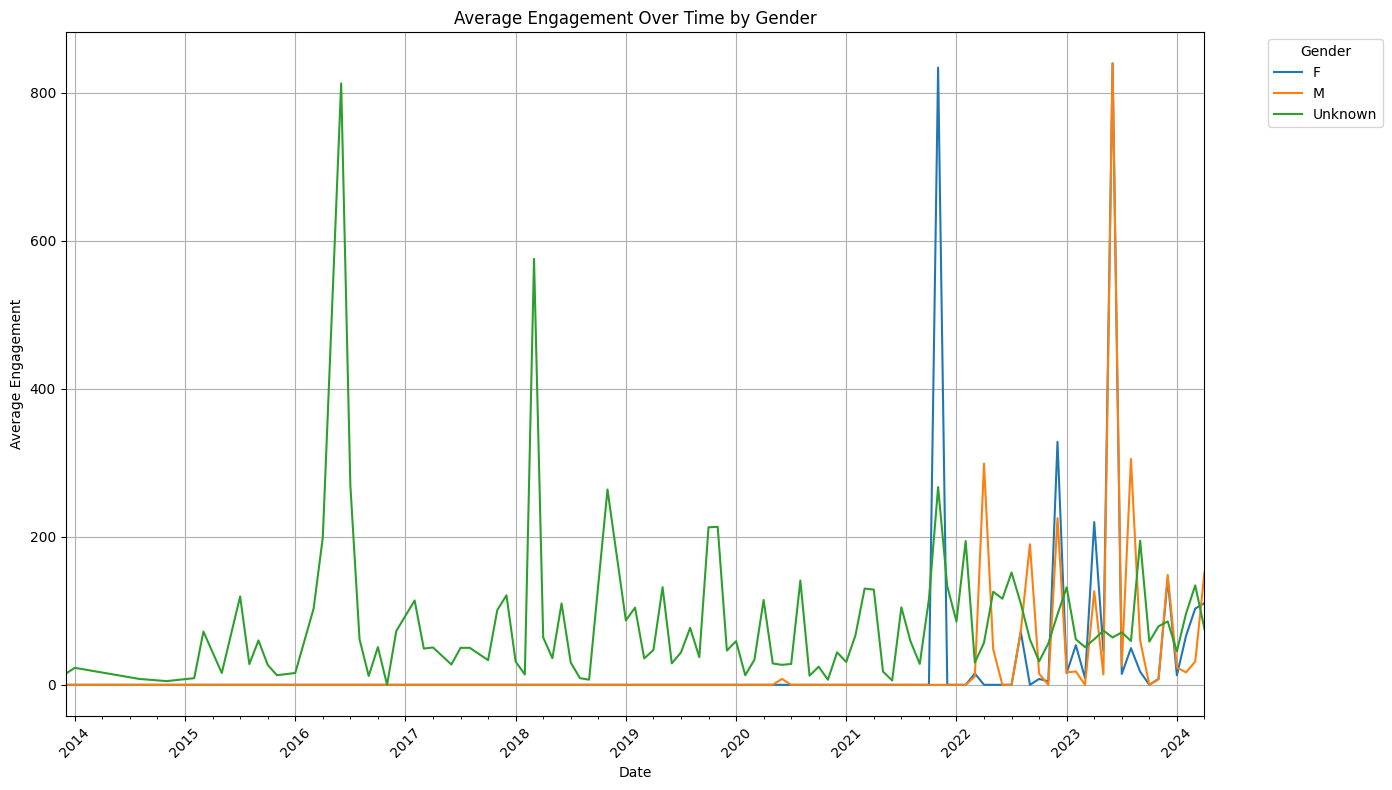

gender          F         M   Unknown
gender                               
F        1.000000  0.650006  0.103725
M        0.650006  1.000000 -0.028185
Unknown  0.103725 -0.028185  1.000000


In [28]:
df['gender'] = df['gender'].replace('unknown', 'Unknown')

monthly_engagement_gender_filtered = df[df['gender'] != 'nan']

monthly_engagement_gender_grouped = monthly_engagement_gender_filtered.groupby(['year_month', 'gender'])['engagement'].mean().reset_index()

gender_engagement_pivot = monthly_engagement_gender_grouped.pivot(index='year_month', columns='gender', values='engagement').fillna(0)

gender_engagement_pivot.plot(kind='line', figsize=(14, 8))
plt.title('Average Engagement Over Time by Gender')
plt.xlabel('Date')
plt.ylabel('Average Engagement')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

correlation_matrix_gender = gender_engagement_pivot.corr()
print(correlation_matrix_gender)


# Model 2

— Explore potential correlations between **events (e.g. holidays)**, and **engagement** in gender-violence-related discussions

In [29]:
holidays = pd.read_csv('ph_holidays.csv')

In [30]:
holidays['Date'] = pd.to_datetime(holidays['Date'], format='%m-%d')
df['post_date'] = pd.to_datetime(df['post_date'])

In [31]:
df['month_day'] = df['post_date'].dt.strftime('%m-%d')
holidays['month_day'] = holidays['Date'].dt.strftime('%m-%d')

In [32]:
merged_df = pd.merge(df, holidays, how='left', left_on='month_day', right_on='month_day')

In [33]:
merged_df['Holiday'] = merged_df['Holiday'].fillna('No Holiday')
merged_df['Type'] = merged_df['Type'].fillna('No Type')

In [34]:
holiday_engagement = merged_df.groupby(['year_month', 'Holiday'])['engagement'].mean().reset_index()

In [35]:
holiday_engagement_pivot = holiday_engagement.pivot(index='year_month', columns='Holiday', values='engagement').fillna(0)

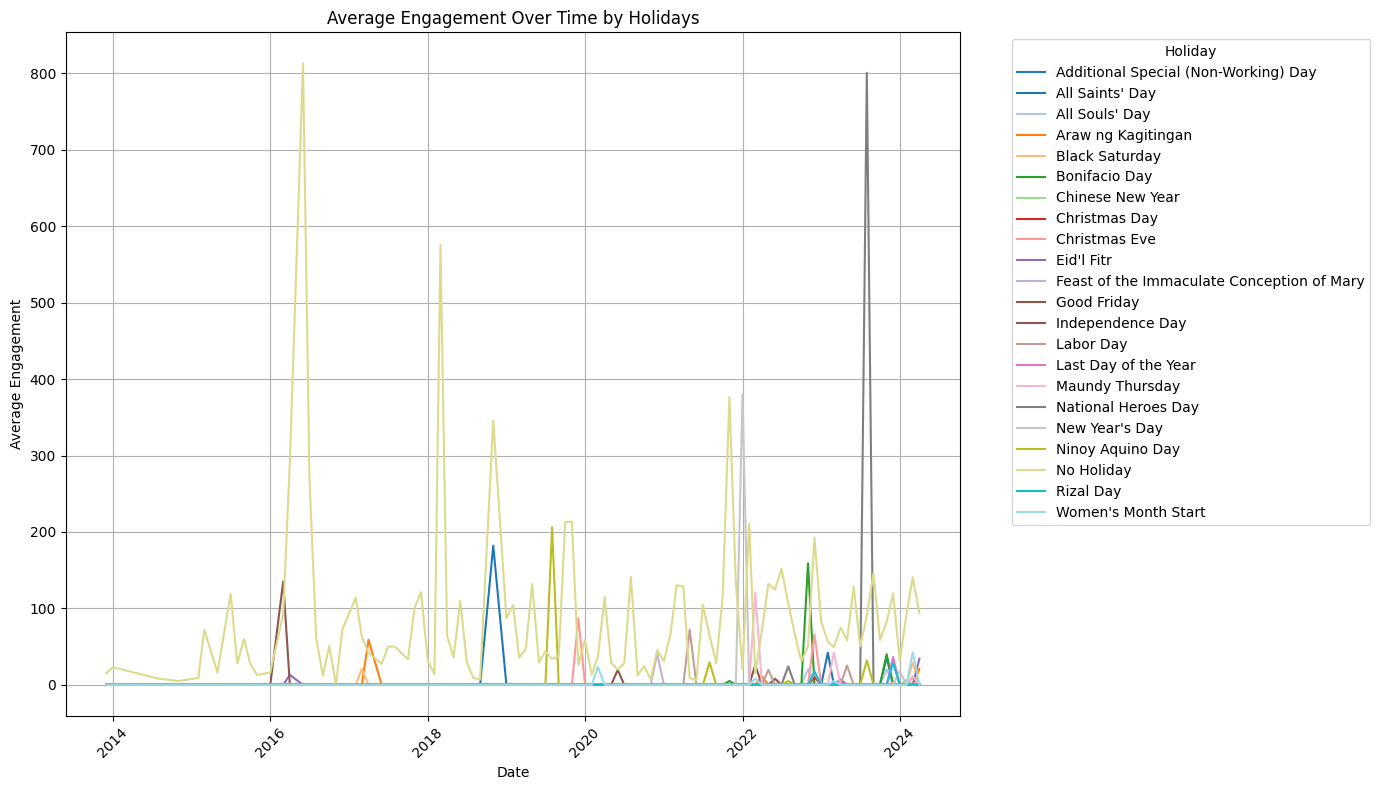

In [36]:
if isinstance(holiday_engagement_pivot.index, pd.PeriodIndex):
    holiday_engagement_pivot.index = holiday_engagement_pivot.index.to_timestamp()

num_holidays = holiday_engagement_pivot.columns.size

cmap = plt.colormaps.get_cmap('tab20')
colors = [cmap(i / num_holidays) for i in range(num_holidays)]

fig, ax = plt.subplots(figsize=(14, 8))
for i, column in enumerate(holiday_engagement_pivot.columns):
    ax.plot(holiday_engagement_pivot.index, holiday_engagement_pivot[column], label=column, color=colors[i])

plt.title('Average Engagement Over Time by Holidays')
plt.xlabel('Date')
plt.ylabel('Average Engagement')

plt.legend(title='Holiday', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
correlation_matrix = holiday_engagement_pivot.corr()
correlation_matrix

Holiday,Additional Special (Non-Working) Day,All Saints' Day,All Souls' Day,Araw ng Kagitingan,Black Saturday,Bonifacio Day,Chinese New Year,Christmas Day,Christmas Eve,Eid'l Fitr,...,Independence Day,Labor Day,Last Day of the Year,Maundy Thursday,National Heroes Day,New Year's Day,Ninoy Aquino Day,No Holiday,Rizal Day,Women's Month Start
Holiday,,,,,,,,,,,,,,,,,,,,,
Additional Special (Non-Working) Day,1.000000,-0.011319,-0.013664,-0.014254,-0.013484,-0.011998,-0.011014,-0.009615,-0.013800,-0.014074,...,-0.012588,-0.014356,-0.009615,-0.013089,-0.009902,-0.010065,-0.012482,-0.027201,-0.013296,-0.015470
All Saints' Day,-0.011319,1.000000,0.122712,-0.016779,-0.015873,0.034089,-0.012965,-0.011319,-0.016245,-0.016568,...,-0.014819,-0.016900,-0.011319,-0.015409,-0.011657,-0.011848,-0.014693,0.224181,-0.015652,-0.018211
All Souls' Day,-0.013664,0.122712,1.000000,-0.020255,-0.019161,0.858610,-0.015651,-0.013664,-0.019610,-0.020000,...,-0.017888,-0.020401,-0.013664,-0.018601,-0.014071,-0.014302,-0.017737,-0.026164,-0.018894,-0.021984
Araw ng Kagitingan,-0.014254,-0.016779,-0.020255,1.000000,-0.019988,-0.017786,-0.016326,-0.014254,-0.020457,0.292904,...,-0.018660,-0.021282,-0.014254,-0.019404,-0.014679,-0.014920,-0.018503,-0.038564,-0.019710,-0.022932
Black Saturday,-0.013484,-0.015873,-0.019161,-0.019988,1.000000,-0.016826,-0.015445,-0.013484,-0.019352,-0.019736,...,-0.017653,-0.020132,-0.013484,0.054466,-0.013886,-0.014114,-0.017504,0.026001,-0.018645,0.690535
Bonifacio Day,-0.011998,0.034089,0.858610,-0.017786,-0.016826,1.000000,-0.013743,-0.011998,-0.017220,-0.017562,...,-0.015708,-0.017914,-0.011998,-0.016333,-0.012356,-0.012559,-0.015575,-0.024849,-0.016591,-0.019304
Chinese New Year,-0.011014,-0.012965,-0.015651,-0.016326,-0.015445,-0.013743,1.000000,-0.011014,-0.015807,-0.016121,...,-0.014419,-0.016444,-0.011014,-0.014993,-0.011342,-0.011528,-0.014297,0.021621,-0.015230,-0.017720
Christmas Day,-0.009615,-0.011319,-0.013664,-0.014254,-0.013484,-0.011998,-0.011014,1.000000,0.599238,-0.014074,...,-0.012588,-0.014356,-0.009615,-0.013089,-0.009902,-0.010065,-0.012482,0.093079,0.520943,-0.015470
Christmas Eve,-0.013800,-0.016245,-0.019610,-0.020457,-0.019352,-0.017220,-0.015807,0.599238,1.000000,-0.020199,...,-0.018066,-0.020604,0.014065,-0.018786,-0.014211,-0.014445,-0.017914,0.013981,0.329094,-0.022203
